<a href="https://colab.research.google.com/github/oilportrait/test_colab/blob/main/linear_models_for_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

문제 1

In [1]:
import pandas as pd
targetUrl = "https://raw.githubusercontent.com/oilportrait/test_colab/main/auto-mpg.csv"
df = pd.read_csv(targetUrl, sep=',')
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [2]:
df.drop('car name', axis=1, inplace=True)
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,18.0,8,307.0,130,3504,12.0,70,1
1,15.0,8,350.0,165,3693,11.5,70,1
2,18.0,8,318.0,150,3436,11.0,70,1
3,16.0,8,304.0,150,3433,12.0,70,1
4,17.0,8,302.0,140,3449,10.5,70,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 25.0+ KB


결측치가 ?로 표시되어있기에 ?를 결측치 표기인 nan으로 바꿔준다

In [13]:
import numpy as np

df.replace("?", np.nan, inplace=True)

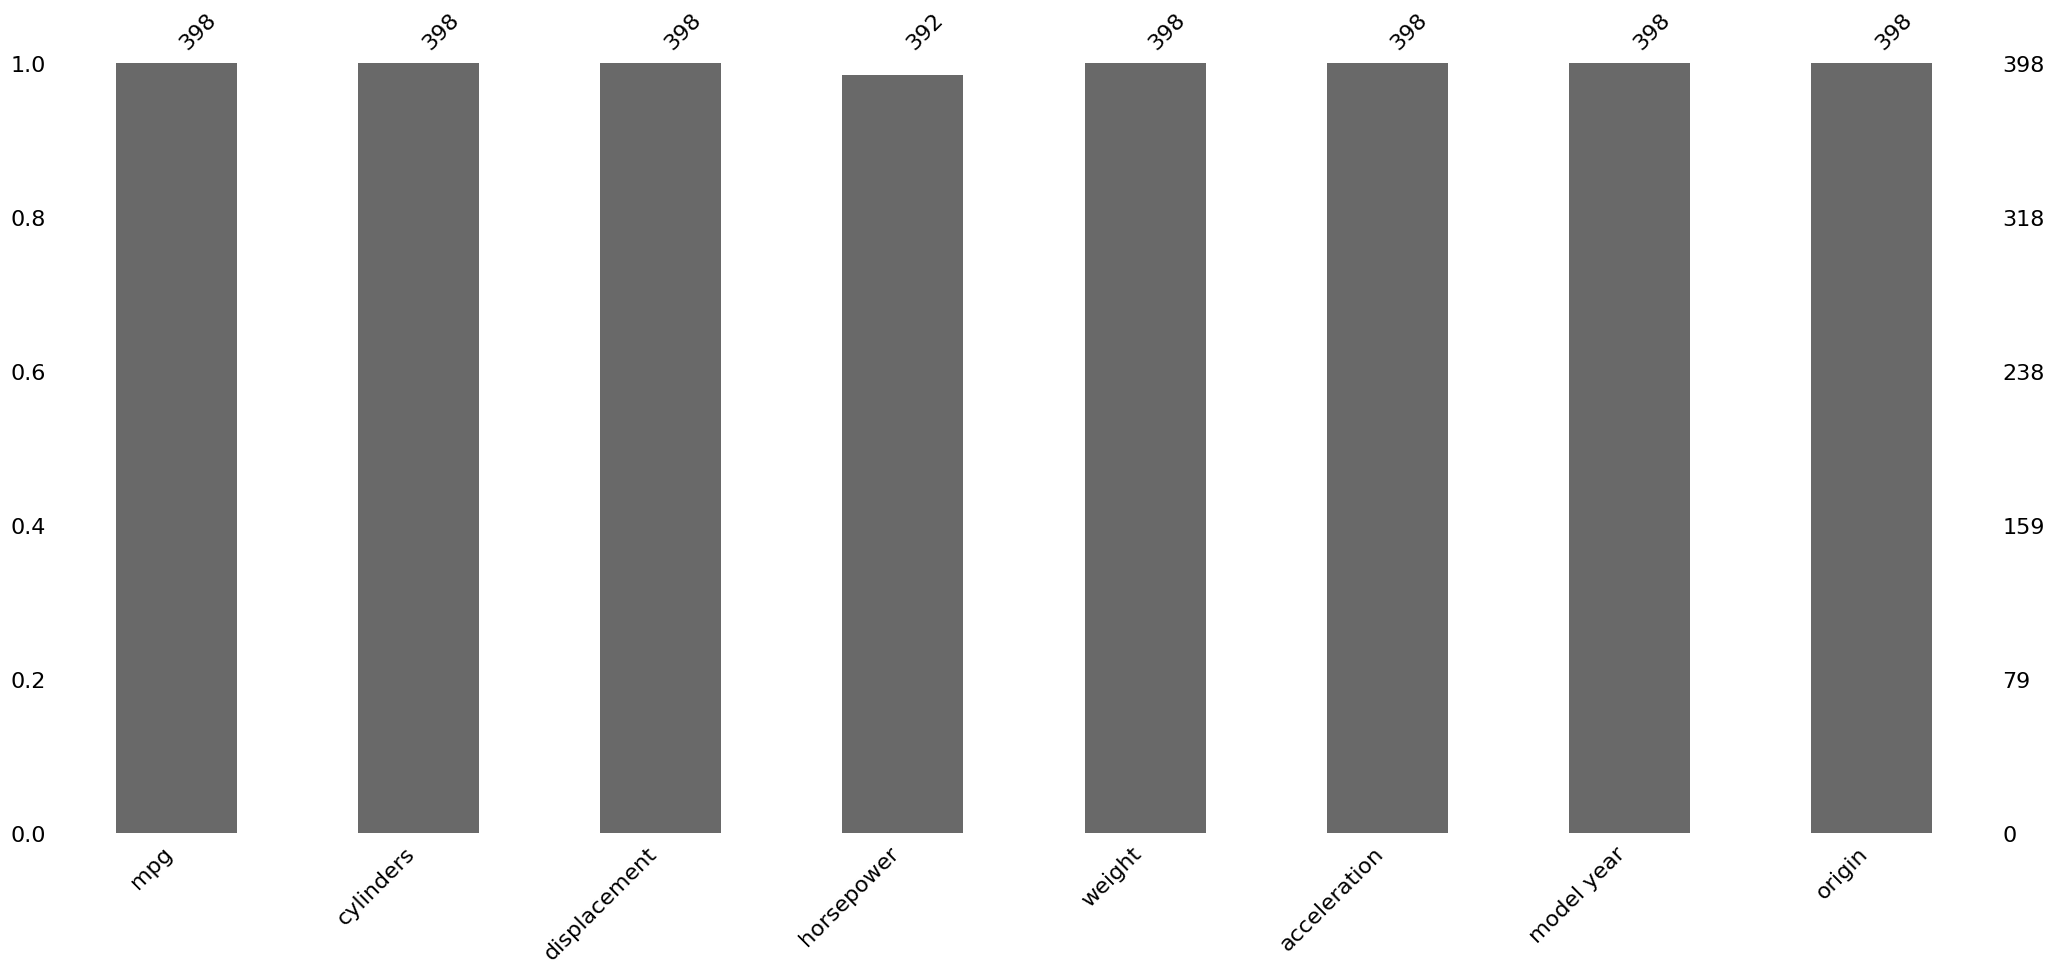

In [16]:
import missingno as msno
import matplotlib.pyplot as plt

msno.bar(df)
plt.show()

결측치를 knn을 이용해서 채워준다

<Axes: >

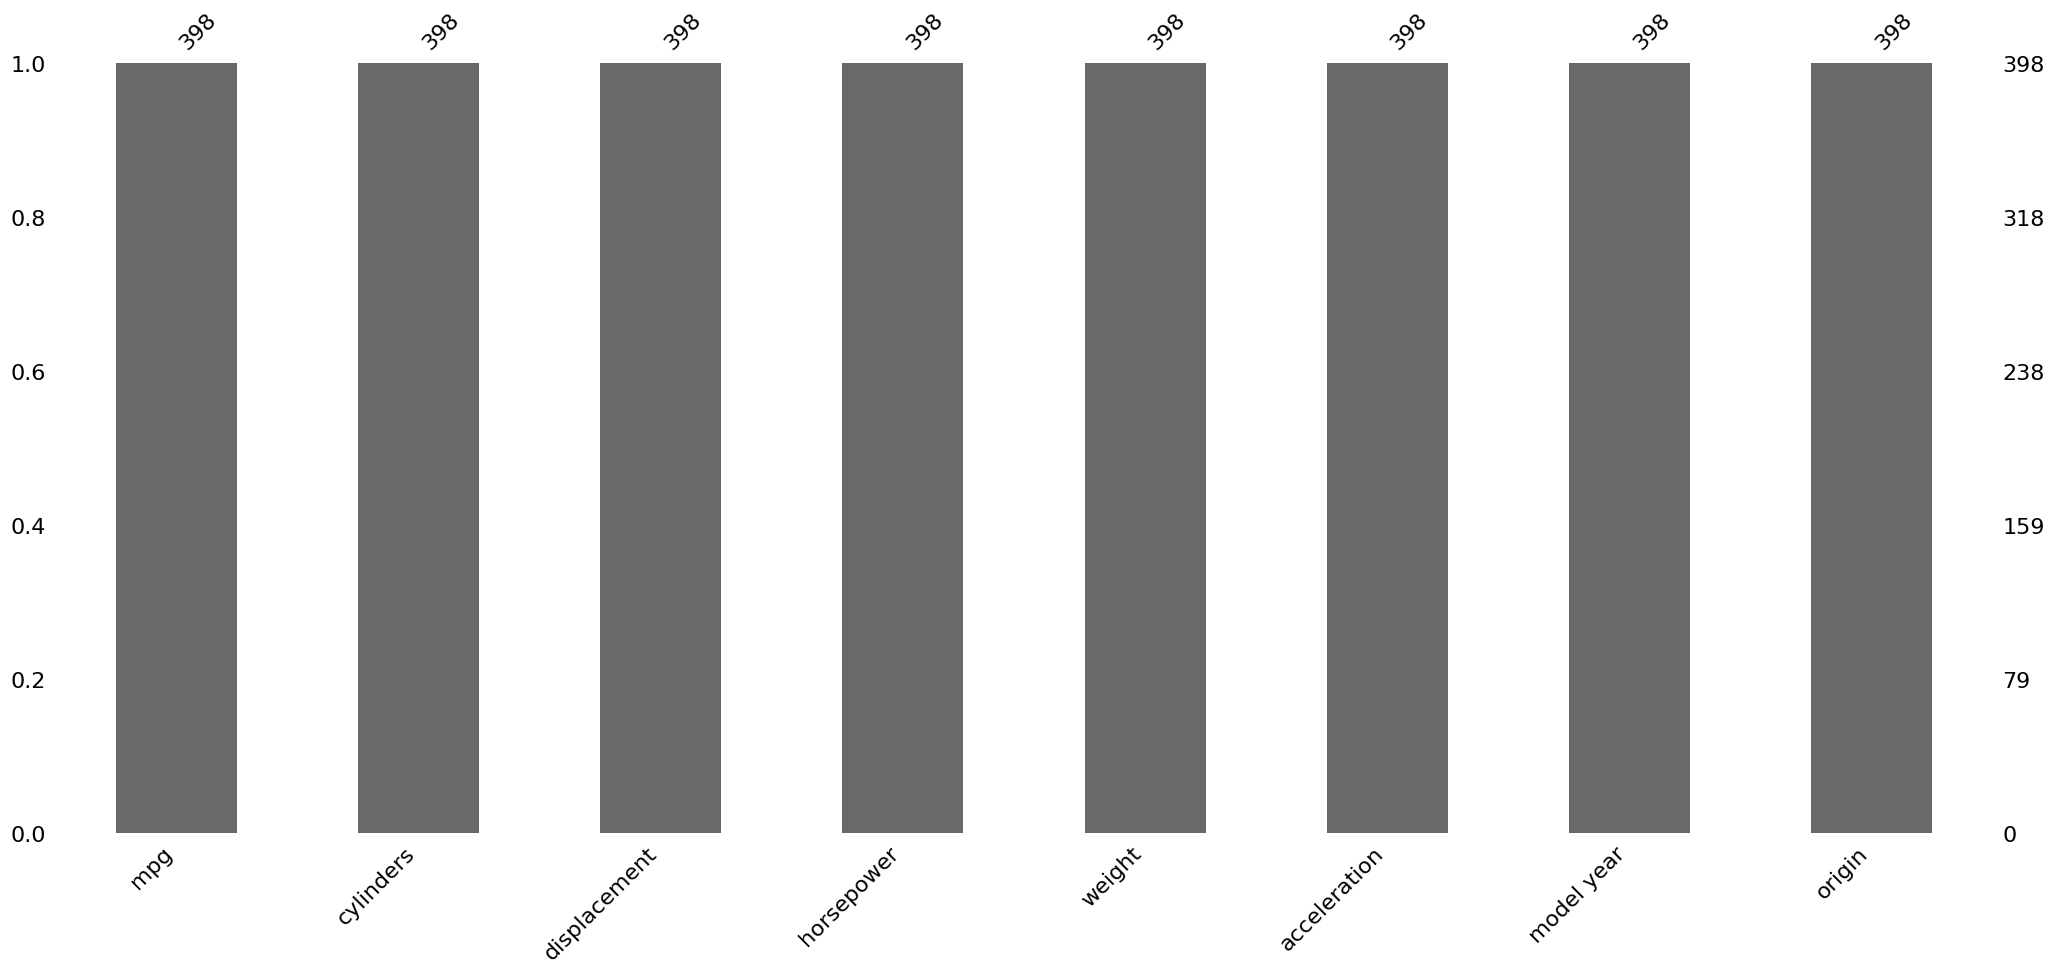

In [18]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)

df[["horsepower"]] = imputer.fit_transform(df[["horsepower"]])
msno.bar(df)

선형회귀에 앞서서 변수들간의 독립 여부를 확인해서 독립이 아닌 변수들은 제거하고자 한다.
이는 차원축소법으로 실현 가능하다.

우선 독립변수와 종속 변수를 설정하고 스케일을 맞추기 위해서 표준화를 시켜준다.

In [44]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

X = df[["cylinders","displacement","horsepower", "weight", "acceleration", "model year", "origin"]]
y = df["mpg"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



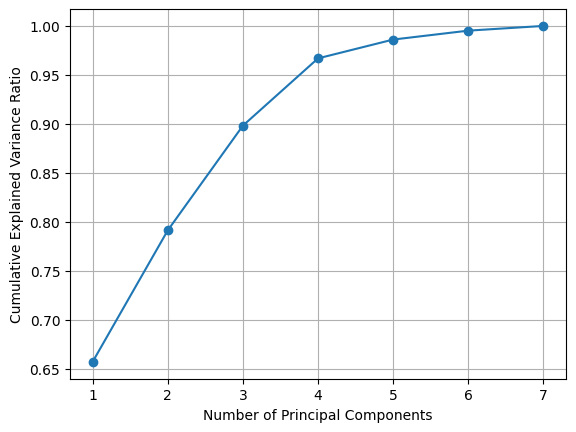

In [46]:
import matplotlib.pyplot as plt
pca = PCA()
X_transformed = pca.fit_transform(X_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)


plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

위 그래프를 근거 삼아 메인 속성을 4개로 설정한다.

In [55]:
pca = PCA(n_components=4)
X_transformed = pca.fit_transform(X_scaled)

1차에서 5차까지 k-fold validation을 이용해서 mean square error를 계산한다.

In [56]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error

poly_orders = range(1, 6)
cv_scores = []

for order in poly_orders:
    polynomial_features = PolynomialFeatures(degree=order)
    X_poly = polynomial_features.fit_transform(X_transformed)

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    reg_model = LinearRegression()
    scores = -cross_val_score(reg_model, X_poly, y, cv=kfold, scoring='neg_mean_squared_error')

    cv_scores.append(scores.mean())
print(cv_scores)

[13.27685222978744, 9.383317369493012, 7.960205306248757, 10.830381322031304, 33.90306550005682]


위의 결과는 3차 다항식으로 선형 회귀를 했을 경우 가장 우수하다는 것을 알려준다.

문제 2

In [62]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

poly_degree = 3

model = make_pipeline(PolynomialFeatures(degree=poly_degree), Ridge())

param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

best_alpha = grid_search.best_params_['ridge__alpha']
best_score = -grid_search.best_score_
print("Best alpha:", best_alpha)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.94654e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.31852e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.17383e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.91985e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarnin

Best alpha: 10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.43329e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.28374e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.37067e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.11333e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


가장 이상적인 알파 값은 10이다.